In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt

## Loading the Dataset

In [2]:
#looking at the preprocessed data
df = pd.read_csv("cleaned_dataset.csv")
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0


## Splitting the dataset into training and test set

In [3]:
X = df.drop(["cardio"],axis=1)
y = df["cardio"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

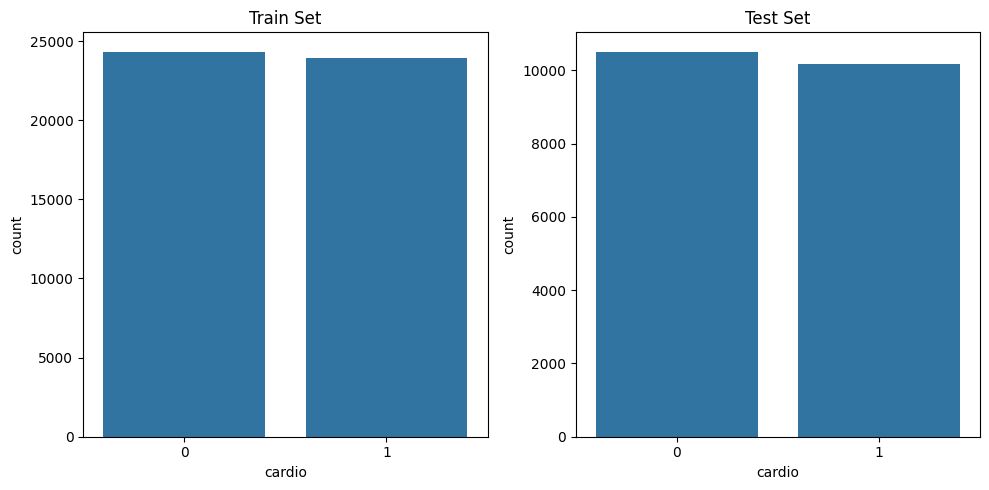

In [4]:
#looking at the counts for training and test dataset
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.countplot(data=df, x = y_train, ax = ax[0])
ax[0].set_title("Train Set")
sns.countplot(data=df, x = y_test, ax = ax[1])
ax[1].set_title("Test Set")
plt.tight_layout()

## Choosing the network architecture

### Wide and short

In [5]:
# Define model
model = Sequential()
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)


In [6]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=0)

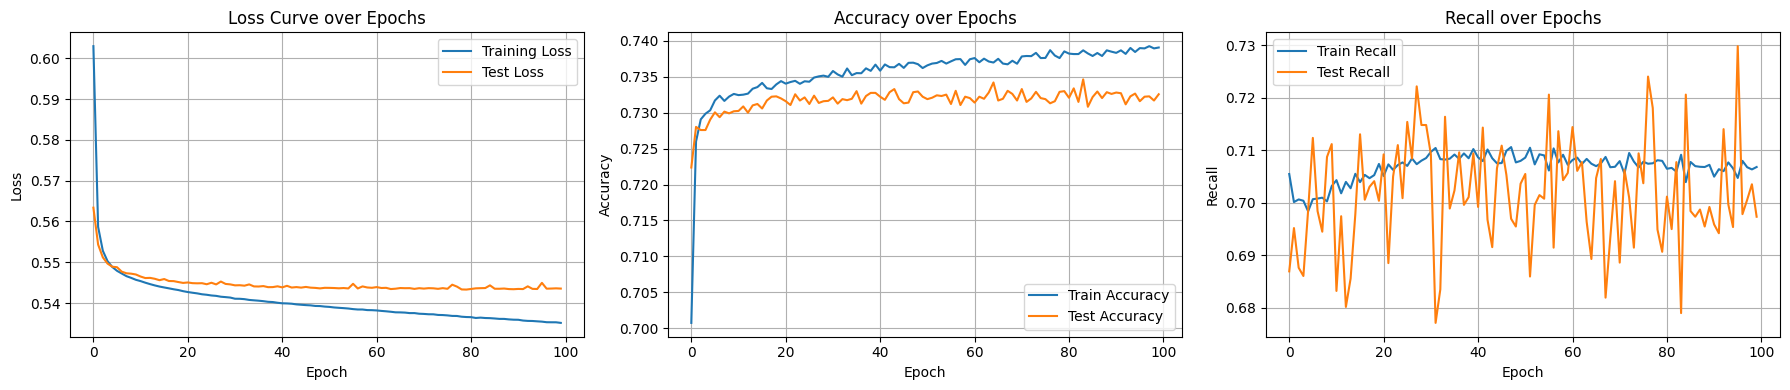

In [15]:
plt.figure(figsize=(18, 4))

# Plotting
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve over Epochs')
plt.legend()
plt.grid(True)
# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [10]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8062,2453
Actual 1,3083,7102


In [16]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.26%
Precision: 74.33%
Recall: 69.73%
F1_score: 71.96%


### Deep and Narrow

In [17]:
model = Sequential()

model.add(Dense(units= 100, activation= ReLU()))
model.add(Dense(units= 90, activation= ReLU()))
model.add(Dense(units= 80, activation= ReLU()))
model.add(Dense(units= 70, activation= ReLU()))
model.add(Dense(units= 60, activation= ReLU()))
model.add(Dense(units= 50, activation= ReLU()))
model.add(Dense(units= 40, activation= ReLU()))
model.add(Dense(units= 30, activation=ReLU()))
model.add(Dense(units= 20, activation= ReLU()))
model.add(Dense(units=1, activation="sigmoid"))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

In [18]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=0)

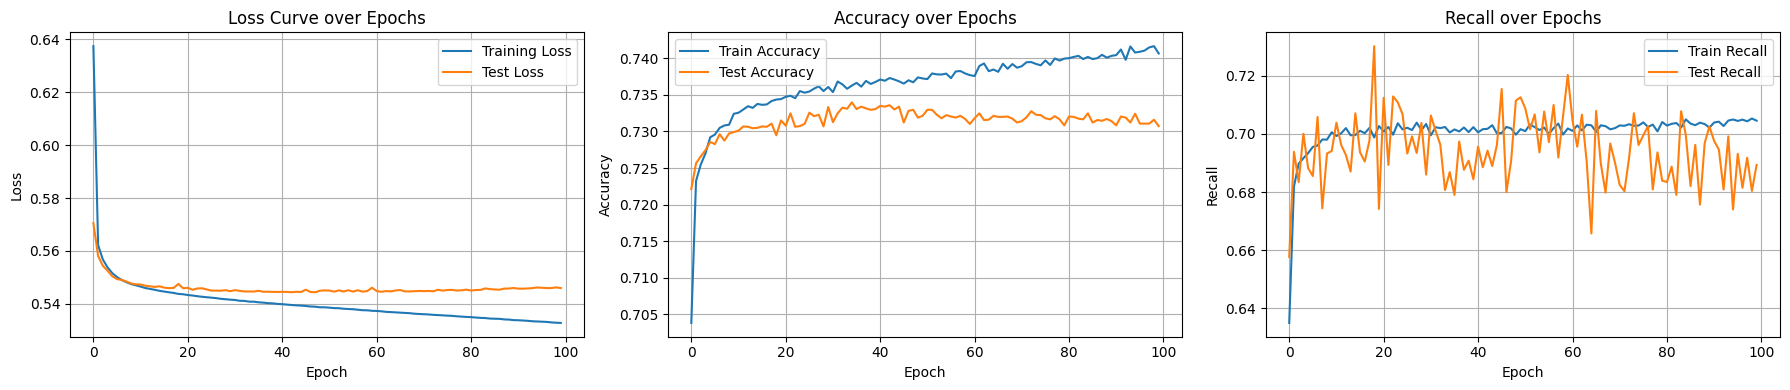

In [19]:
plt.figure(figsize=(18, 4))

# Plotting
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve over Epochs')
plt.legend()
plt.grid(True)
# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [25]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8105,2410
Actual 1,3164,7021


In [26]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.07%
Precision: 74.45%
Recall: 68.93%
F1_score: 71.58%


### Medium

In [28]:
model = Sequential()

model.add(Dense(units= 256, activation= ReLU()))
model.add(Dense(units= 128, activation= ReLU()))
model.add(Dense(units= 64, activation= ReLU()))
model.add(Dense(units= 32, activation= ReLU()))
model.add(Dense(units= 16, activation= ReLU()))
model.add(Dense(units= 8, activation= ReLU()))
model.add(Dense(units=1, activation="sigmoid"))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

In [29]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=0)

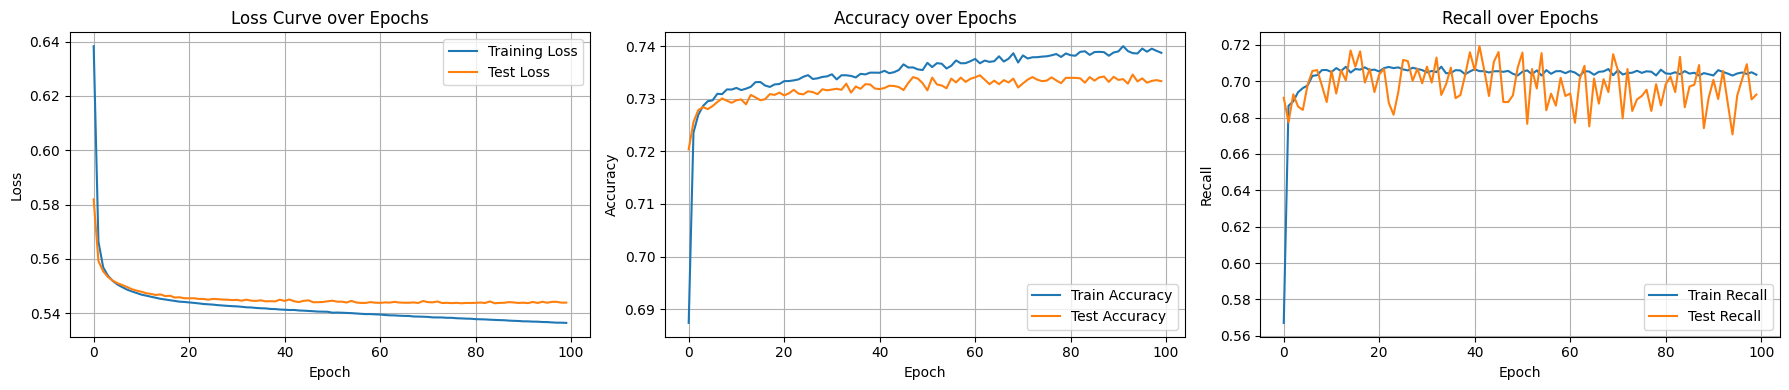

In [30]:
plt.figure(figsize=(18, 4))

# Plotting
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve over Epochs')
plt.legend()
plt.grid(True)
# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [32]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8125,2390
Actual 1,3130,7055


In [33]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.33%
Precision: 74.70%
Recall: 69.27%
F1_score: 71.88%
